#### **<span style="font-family: monospace;">> Syslog Analysis</span>**

Researcher: Andrei Batyrov, (C) 2021-2024

##### Table of Contents

1. [Description](#description)

2. [Load and Parse Data](#load-data)

3. [Basic Apache Spark Transformations and Actions](#trans)

4. [Message Distribution over Time](#time)

5. [Message Embeddings](#embed)

6. [Plot Results](#plot)

7. [Summary](#summary)

##### <a id="description"></a>1. Description

Customer network devices collect piles of system messages, collectively referred to as "syslog". Some messages are well documented and rather easily identifiable, while many others either do not have meaningful description or occur not frequently but still may indicate degradation of service. _The goal_ is to cluster the messages into meaningful groups. Messages falling in the same group ideally should have similar semantics.

Challenges:
- large amount of data,
- text/csv format,
- customer wants to convert raw text data into meaningful actionable items.

Suggested approach:
- use Apache Spark Resilient Distributed Dataset, DataFrame, and SQL to work with big data,
- use Natural Language Processing techniques to extract features from the messages,
- use clustering, embedding, and dimensionality reduction techniques to group messages,
- assess and extract new information from the obtained groups.

In [1]:
# Essential import
import re
import string
from datetime import datetime as dt
import pyspark
from pyspark.sql import SparkSession, Row, functions as F
from pyspark.sql.functions import avg, countDistinct, udf, col
from pyspark.sql.types import StringType
#from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import findspark
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib import offsetbox, cm
pd.set_option('display.max_columns', 50) # set to larger value to see all the columns of pd.DF
seed = 42

##### <a id="load-data"></a>2. Load and Parse Data

In [2]:
# This is to find and init Spark
findspark.init()

In [3]:
# Create Spark context to work with RDD
sc = pyspark.SparkContext(appName='syslog_rdd')

In [4]:
# Read data into RDD
# Cache the data to speed up future actions
filename = 'data.txt'
data = sc.textFile(filename).cache()

In [6]:
data.take(5)

['hostname;c1;c2;date_time;c4;severity;message;count',
 'CCM-TFTP-MSK;;;2019-1-15 23:45:04;;3;%UC_AUDITLOG-3-AdministrativeEvent: %[ UserID =avsamok3][ ClientAddress =10.73.222.40][ Severity =3][ EventType =UserLogging][ ResourceAccessed=cucm-uds][ EventStatus =Failure][ CompulsoryEvent =No][ AuditCategory =AdministrativeEvent][ ComponentID =Cisco CCM Application][ AuditDetails =Login Authentication Failed][App ID=Cisco Tomcat][Cluster ID=][Node ID=CCM-TFTP-MSK]: Audit Event is generated by this application ;540',
 'ccm-pub-msk;;;2019-1-15 23:45:05;;3;%UC_AUDITLOG-3-AdministrativeEvent: %[ UserID =CCM_TMS][ ClientAddress =10.73.222.65][ Severity =3][ EventType =UserLogging][ ResourceAccessed=Soap Real Time Service 2][ EventStatus =Success][ CompulsoryEvent =No][ AuditCategory =AdministrativeEvent][ ComponentID =Cisco CCM Application][ AuditDetails =Login Authentication Successful][App ID=Cisco Tomcat][Cluster ID=][Node ID=ccm-pub-msk]: Audit Event is generated by this application ;6560

In [7]:
# Remove the top row (header)
top_row = data.first()
data = data.filter(lambda line: line != top_row).cache()

Raw message count and sample 5 messages. Right now it looks as chaotic.

In [8]:
data.count()

22632

In [11]:
data.take(5)

['CCM-TFTP-MSK;;;2019-1-15 23:45:04;;3;%UC_AUDITLOG-3-AdministrativeEvent: %[ UserID =avsamok3][ ClientAddress =10.73.222.40][ Severity =3][ EventType =UserLogging][ ResourceAccessed=cucm-uds][ EventStatus =Failure][ CompulsoryEvent =No][ AuditCategory =AdministrativeEvent][ ComponentID =Cisco CCM Application][ AuditDetails =Login Authentication Failed][App ID=Cisco Tomcat][Cluster ID=][Node ID=CCM-TFTP-MSK]: Audit Event is generated by this application ;540',
 'ccm-pub-msk;;;2019-1-15 23:45:05;;3;%UC_AUDITLOG-3-AdministrativeEvent: %[ UserID =CCM_TMS][ ClientAddress =10.73.222.65][ Severity =3][ EventType =UserLogging][ ResourceAccessed=Soap Real Time Service 2][ EventStatus =Success][ CompulsoryEvent =No][ AuditCategory =AdministrativeEvent][ ComponentID =Cisco CCM Application][ AuditDetails =Login Authentication Successful][App ID=Cisco Tomcat][Cluster ID=][Node ID=ccm-pub-msk]: Audit Event is generated by this application ;65602',
 'ccm-sub3-msk;;;2019-1-15 23:45:06;;3;%UC_CALLMANA

In [12]:
# Define the syslog message format to parse
log_format = re.compile(
    r'(?P<hostname>.*?);;'
    r';(?P<datetime>\d+.*?);'
    r';(?P<severity>\d)'
    r';(?P<header>%.*?)\:\s.*?'
    r'(?:%\[ UserID =(?P<userid>.+)\])?'
    r'(?:\[ ClientAddress =)?'
    #r'(?:\[Device IP address=)?'
    r'(?P<ip>[\d\.]+)\].*'
    r':\s(?P<body>.+)\s?;'
)

In [13]:
def parseEntry(entry: str):
    match = log_format.match(entry)
    # If log_format not matched, we must return a tuple with empty strings,
    # since None object is not accepted by Spark
    if not match:
        return {'date_time': '', 'date': '', 'time_hour': '', 'ip': '', 'hostname': '', 'severity': '', 'userid': '', 'header': '', 'body': ''}
    parsed = {
        'date_time': dt.strptime(match.group('datetime'), '%Y-%m-%d %H:%M:%S'),
        'date': dt.strptime(match.group('datetime'), '%Y-%m-%d %H:%M:%S').date(), # Extract also date
        'time_hour': dt.strptime(match.group('datetime'), '%Y-%m-%d %H:%M:%S').hour, # Extract also hour
        'ip': match.group('ip'),
        'hostname': match.group('hostname'),
        'severity': match.group('severity'),
        'userid': match.group('userid'),
        'header': match.group('header'),
        'body': match.group('body')
    }
    return parsed

In [14]:
# Read the syslog messages into memory and transform (map)
parsed_logs = data.map(parseEntry)

In [15]:
parsed_logs.take(2)

[{'date_time': datetime.datetime(2019, 1, 15, 23, 45, 4),
  'date': datetime.date(2019, 1, 15),
  'time_hour': 23,
  'ip': '10.73.222.40',
  'hostname': 'CCM-TFTP-MSK',
  'severity': '3',
  'userid': 'avsamok3',
  'header': '%UC_AUDITLOG-3-AdministrativeEvent',
  'body': 'Audit Event is generated by this application '},
 {'date_time': datetime.datetime(2019, 1, 15, 23, 45, 5),
  'date': datetime.date(2019, 1, 15),
  'time_hour': 23,
  'ip': '10.73.222.65',
  'hostname': 'ccm-pub-msk',
  'severity': '3',
  'userid': 'CCM_TMS',
  'header': '%UC_AUDITLOG-3-AdministrativeEvent',
  'body': 'Audit Event is generated by this application '}]

In [16]:
# Convert to Rows objects
rdd = parsed_logs.map(lambda x: Row(**x))

In [17]:
rdd.take(2)

[Row(date_time=datetime.datetime(2019, 1, 15, 23, 45, 4), date=datetime.date(2019, 1, 15), time_hour=23, ip='10.73.222.40', hostname='CCM-TFTP-MSK', severity='3', userid='avsamok3', header='%UC_AUDITLOG-3-AdministrativeEvent', body='Audit Event is generated by this application '),
 Row(date_time=datetime.datetime(2019, 1, 15, 23, 45, 5), date=datetime.date(2019, 1, 15), time_hour=23, ip='10.73.222.65', hostname='ccm-pub-msk', severity='3', userid='CCM_TMS', header='%UC_AUDITLOG-3-AdministrativeEvent', body='Audit Event is generated by this application ')]

In [18]:
# Create Spark session to work with DataFrames
spark = SparkSession.builder.appName('syslog_df').getOrCreate()

In [30]:
# Create a DataFrame from RDD
schema = '''
            date_time: string, 
            date: string, 
            time_hour: string, 
            ip: string, 
            hostname: string, 
            severity: string, 
            userid: string, 
            header: string, 
            body: string
            '''
df = spark.createDataFrame(rdd, schema=schema).cache()
# Convert GregorianCalender date to human-readable date
date_pat = r'(?:.*)YEAR=(\d+).+?MONTH=(\d+).+?DAY_OF_MONTH=(\d+).+'
df = df\
        .withColumn('year_human', F.regexp_replace('date', date_pat, '$1'))\
        .withColumn('month_human', F.regexp_replace('date', date_pat, '$2'))\
        .withColumn('day_human', F.regexp_replace('date', date_pat, '$3'))\
        .withColumn('date_human', F.concat(F.col('year_human'), F.lit('-'), (F.col('month_human') + 1.).cast('int'), F.lit('-'), F.col('day_human')))\
        .drop('year_human', 'month_human', 'day_human')

Parsed messages already look much more meaningful.

In [31]:
df.show(10)

+--------------------+--------------------+---------+-------------+------------+--------+----------------+--------------------+--------------------+----------+
|           date_time|                date|time_hour|           ip|    hostname|severity|          userid|              header|                body|date_human|
+--------------------+--------------------+---------+-------------+------------+--------+----------------+--------------------+--------------------+----------+
|java.util.Gregori...|java.util.Gregori...|       23| 10.73.222.40|CCM-TFTP-MSK|       3|        avsamok3|%UC_AUDITLOG-3-Ad...|Audit Event is ge...| 2019-1-15|
|java.util.Gregori...|java.util.Gregori...|       23| 10.73.222.65| ccm-pub-msk|       3|         CCM_TMS|%UC_AUDITLOG-3-Ad...|Audit Event is ge...| 2019-1-15|
|java.util.Gregori...|java.util.Gregori...|       23|         5060|ccm-sub3-msk|       3|            NULL|%UC_CALLMANAGER-3...|An endpoint attem...| 2019-1-15|
|java.util.Gregori...|java.util.Gregori.

In [32]:
df.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time_hour: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- severity: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- header: string (nullable = true)
 |-- body: string (nullable = true)
 |-- date_human: string (nullable = true)



##### <a id="trans"></a>3. Basic Apache Spark Transformations and Actions

In [33]:
# Drop rows with all empty values
# We can't use dropna() here, since values are just empty strings, but not nulls, in fact
df = df.where(df['date_human'] != '')

In [34]:
df.count()

22337

In [35]:
df.show(10)

+--------------------+--------------------+---------+-------------+------------+--------+----------------+--------------------+--------------------+----------+
|           date_time|                date|time_hour|           ip|    hostname|severity|          userid|              header|                body|date_human|
+--------------------+--------------------+---------+-------------+------------+--------+----------------+--------------------+--------------------+----------+
|java.util.Gregori...|java.util.Gregori...|       23| 10.73.222.40|CCM-TFTP-MSK|       3|        avsamok3|%UC_AUDITLOG-3-Ad...|Audit Event is ge...| 2019-1-15|
|java.util.Gregori...|java.util.Gregori...|       23| 10.73.222.65| ccm-pub-msk|       3|         CCM_TMS|%UC_AUDITLOG-3-Ad...|Audit Event is ge...| 2019-1-15|
|java.util.Gregori...|java.util.Gregori...|       23|         5060|ccm-sub3-msk|       3|            NULL|%UC_CALLMANAGER-3...|An endpoint attem...| 2019-1-15|
|java.util.Gregori...|java.util.Gregori.

In [36]:
# Select some column(s)
df.select('hostname').show(10)

+------------+
|    hostname|
+------------+
|CCM-TFTP-MSK|
| ccm-pub-msk|
|ccm-sub3-msk|
| ccm-pub-msk|
|ccm-sub6-msk|
|ccm-sub6-msk|
|CCM-TFTP-MSK|
| ccm-pub-msk|
|ccm-sub4-msk|
|ccm-sub4-msk|
+------------+
only showing top 10 rows



In [37]:
# Filter rows by severity
df.filter(df['severity'] < 3).show()

+--------------------+--------------------+---------+------------+------------+--------+------+--------------------+--------------------+----------+
|           date_time|                date|time_hour|          ip|    hostname|severity|userid|              header|                body|date_human|
+--------------------+--------------------+---------+------------+------------+--------+------+--------------------+--------------------+----------+
|java.util.Gregori...|java.util.Gregori...|        1|     1016017|ccm-sub4-msk|       1|  NULL|%UC_CALLMANAGER-1...| Device unregistered| 2019-1-16|
|java.util.Gregori...|java.util.Gregori...|        1|     1016016|ccm-sub4-msk|       1|  NULL|%UC_CALLMANAGER-1...| Device unregistered| 2019-1-16|
|java.util.Gregori...|java.util.Gregori...|        1|     1016016|ccm-sub6-msk|       1|  NULL|%UC_CALLMANAGER-1...| Device unregistered| 2019-1-16|
|java.util.Gregori...|java.util.Gregori...|        8|  10.36.8.14|ccm-sub4-msk|       2|  NULL|%UC_CALLMAN

Group messages by header

In [38]:
df.groupBy('header').count().sort('count', ascending=False).show(truncate=False)

+--------------------------------------------------------+-----+
|header                                                  |count|
+--------------------------------------------------------+-----+
|%UC_-3-LastOutOfServiceInformation                      |10076|
|%UC_CALLMANAGER-3-EndPointUnregistered                  |5332 |
|%UC_CALLMANAGER-3-RecordingCallSetupFail                |3727 |
|%UC_AUDITLOG-3-AdministrativeEvent                      |2093 |
|%UC_-3-DeviceTLInfo                                     |609  |
|%UC_CALLMANAGER-3-EndPointTransientConnection           |330  |
|%UC_CTI-3-CtiDeviceOpenFailure                          |29   |
|%UC_-3-DeviceApplyConfigResult                          |27   |
|%UC_CALLMANAGER-3-RecordingSessionTerminatedUnexpectedly|23   |
|%UC_-3-DeviceImageDownloadStart                         |21   |
|%UC_-3-DeviceImageDownloadSuccess                       |19   |
|%UC_CALLMANAGER-3-DeviceUnregistered                    |11   |
|%UC_CALLMANAGER-3-SIPNor

Aggregation: get mean message severity

In [39]:
df2 = df.select(avg('severity'))
df2.show()

+------------------+
|     avg(severity)|
+------------------+
|2.9995523123069345|
+------------------+



Count unique ip addresses

In [40]:
df2 = df.select(countDistinct('ip'))
df2.show()

+------------------+
|count(DISTINCT ip)|
+------------------+
|              3876|
+------------------+



In [41]:
# Querying with SQL
# First we need to create a new view in our df
df.createOrReplaceTempView('logs')

Count night message headers

In [42]:
sql_df = spark.sql('''
                    select header, count(*) 
                    from logs 
                    where time_hour < 9 
                    group by header 
                    sort by 2 desc
                    ''')
sql_df.show(10)

+--------------------+--------+
|              header|count(1)|
+--------------------+--------+
|%UC_-3-LastOutOfS...|    3058|
|%UC_CALLMANAGER-3...|    2438|
|%UC_AUDITLOG-3-Ad...|    1239|
| %UC_-3-DeviceTLInfo|     260|
|%UC_CALLMANAGER-3...|     241|
|%UC_CALLMANAGER-3...|     209|
|%UC_-3-DeviceAppl...|      18|
|%UC_CTI-3-CtiDevi...|      16|
|%UC_-3-DeviceImag...|      14|
|%UC_-3-DeviceImag...|      14|
+--------------------+--------+
only showing top 10 rows



##### <a id="time"></a>4. Message Distribution over Time

In [43]:
# Aggregate data over dates to get distributions for each hour
hour_stats_df = df.toPandas()
hour_stats_df['time_hour'] = hour_stats_df['time_hour'].astype(int)
hour_stats_df = hour_stats_df.groupby(['date_human', 'time_hour'])['time_hour'].count().groupby('time_hour')

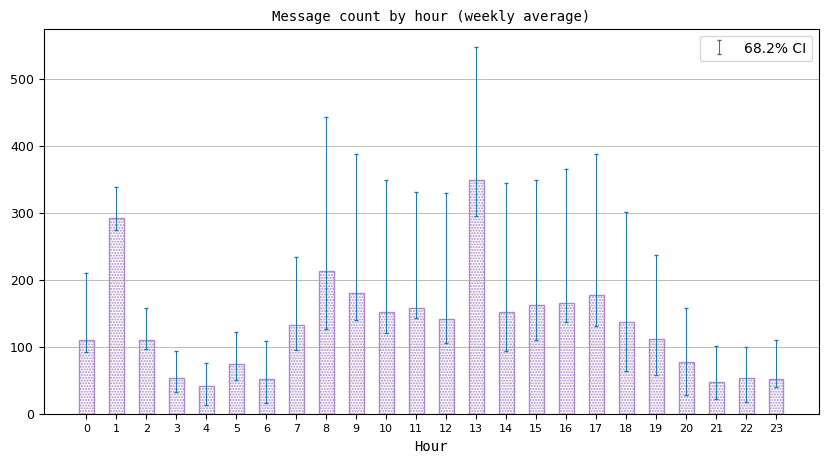

In [44]:
plt.figure(figsize=(10, 5))
plt.bar(x=hour_stats_df.mean().index, 
        height=hour_stats_df.mean(), 
        yerr=[hour_stats_df.quantile(0.0), hour_stats_df.quantile(0.682)],
        width=0.5, 
        color='white', 
        edgecolor='C4', 
        hatch='.'*6, 
        alpha=0.75,
        error_kw={'lw': 0.75, 'ecolor': 'C0', 'capsize': 1.5, 'label': '68.2% CI'})
plt.xticks(hour_stats_df.mean().index, size=8)
plt.yticks(size=9)
plt.xlabel('Hour', size=10, family='monospace')
plt.title('Message count by hour (weekly average)', size=10, family='monospace')
plt.grid(axis='y', lw=0.5, color='xkcd:cement')
plt.legend();

We can see message spikes at `1am` and `1pm`. Also, the one-sigma quantile intervals (68.2% of all messages) signal fat tails of message count distributions virtually for every hour. Let's show the top 10 hostnames and message headers for these hours.

1am

In [45]:
df.createOrReplaceTempView('logs')
spark.sql('''
            select date_human, hostname, header, count(*) 
            from logs 
            where time_hour = 1
            group by date_human, hostname, header 
            sort by 4 desc
            limit 10
            ''').show(truncate=False)

+----------+------------+---------------------------------------------+--------+
|date_human|hostname    |header                                       |count(1)|
+----------+------------+---------------------------------------------+--------+
|2019-1-16 |ccm-sub4-msk|%UC_CALLMANAGER-3-EndPointUnregistered       |1015    |
|2019-1-16 |ccm-sub4-msk|%UC_-3-LastOutOfServiceInformation           |210     |
|2019-1-16 |ccm-sub6-msk|%UC_-3-LastOutOfServiceInformation           |204     |
|2019-1-16 |ccm-pub-msk |%UC_AUDITLOG-3-AdministrativeEvent           |108     |
|2019-1-16 |ccm-sub6-msk|%UC_CALLMANAGER-3-EndPointTransientConnection|73      |
|2019-1-16 |ccm-sub4-msk|%UC_-3-DeviceTLInfo                          |68      |
|2019-1-16 |ccm-sub6-msk|%UC_CALLMANAGER-3-EndPointUnregistered       |61      |
|2019-1-16 |ccm-sub3-msk|%UC_CALLMANAGER-3-EndPointUnregistered       |54      |
|2019-1-20 |ccm-sub3-msk|%UC_-3-LastOutOfServiceInformation           |23      |
|2019-1-19 |ccm-sub4-msk|%UC

1pm

In [46]:
df.createOrReplaceTempView('logs')
spark.sql('''
            select date_human, hostname, header, count(*) 
            from logs 
            where time_hour = 13
            group by date_human, hostname, header 
            sort by 4 desc
            limit 10
            ''').show(truncate=False)

+----------+------------+----------------------------------------+--------+
|date_human|hostname    |header                                  |count(1)|
+----------+------------+----------------------------------------+--------+
|2019-1-16 |ccm-sub4-msk|%UC_CALLMANAGER-3-EndPointUnregistered  |944     |
|2019-1-16 |ccm-sub4-msk|%UC_-3-LastOutOfServiceInformation      |287     |
|2019-1-16 |ccm-sub3-msk|%UC_-3-LastOutOfServiceInformation      |91      |
|2019-1-16 |ccm-sub4-msk|%UC_-3-DeviceTLInfo                     |86      |
|2019-1-17 |ccm-sub3-msk|%UC_-3-LastOutOfServiceInformation      |65      |
|2019-1-18 |ccm-sub3-msk|%UC_-3-LastOutOfServiceInformation      |55      |
|2019-1-15 |ccm-sub3-msk|%UC_-3-LastOutOfServiceInformation      |48      |
|2019-1-17 |ccm-sub3-msk|%UC_CALLMANAGER-3-RecordingCallSetupFail|40      |
|2019-1-15 |ccm-sub4-msk|%UC_-3-LastOutOfServiceInformation      |39      |
|2019-1-16 |ccm-sub3-msk|%UC_CALLMANAGER-3-RecordingCallSetupFail|35      |
+----------+

We can quickly spot the top "offending" hostnames and messages.

##### <a id="embed"></a>5. Message Embeddings

First, let's encode message bodies as token (word) features with Tf-Idf. We might also use Word2Vec or even BERT models for feature extraction to get even better results.

In [47]:
# We will use our own tokenizer
# Or we can use built-in sklearn TfidfVectorizer's tokenizer or pyspark ml's Tokenizer
def vanilla_tokenizer(text):
    text = re.sub(f'[^{re.escape(string.printable)}]', ' ', text)  # replace unprintable characters and punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)  # with a space
    words = text.lower().split()
    return words

In [48]:
# Test
sample_text = "text = re.sub(f'[^{re.escape(string.printable)}]', ' ', text)  # replace unprintable characters with a space"
vanilla_tokenizer(sample_text)

['text',
 're',
 'sub',
 'f',
 're',
 'escape',
 'string',
 'printable',
 'text',
 'replace',
 'unprintable',
 'characters',
 'with',
 'a',
 'space']

In [49]:
# This is needed to apply custom (user-defined) functions to spark df columns element wise
# This is not needed, if using sklearn
vanilla_tokenizer_udf = udf(lambda text: vanilla_tokenizer(text), StringType())

Tokenize message bodies with our tokenizer

In [50]:
# This is not needed, if using sklearn
df = df.withColumn('tokenized_body', vanilla_tokenizer_udf(col('body'))).cache()
df.select(['body', 'tokenized_body']).show(5, truncate=False)

+-------------------------------------------------------------------+------------------------------------------------------------------------------+
|body                                                               |tokenized_body                                                                |
+-------------------------------------------------------------------+------------------------------------------------------------------------------+
|Audit Event is generated by this application                       |[audit, event, is, generated, by, this, application]                          |
|Audit Event is generated by this application                       |[audit, event, is, generated, by, this, application]                          |
|An endpoint attempted to register but did not complete registration|[an, endpoint, attempted, to, register, but, did, not, complete, registration]|
|Audit Event is generated by this application                       |[audit, event, is, generated, by, thi

In [51]:
# Create sklearn TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=vanilla_tokenizer)

In [52]:
# Test
X = tfidf.fit_transform([sample_text])
tfidf.get_feature_names_out()

c:\Users\andre\mambaforge\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['a', 'characters', 'escape', 'f', 'printable', 're', 'replace',
       'space', 'string', 'sub', 'text', 'unprintable', 'with'],
      dtype=object)

Compute Tf-Idf values for each token (word)

In [53]:
X.data

array([0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
       0.22941573, 0.22941573, 0.22941573, 0.22941573, 0.22941573,
       0.22941573, 0.45883147, 0.45883147])

In [54]:
# Tokenize and encode new features (words) extracted from message bodies
X = tfidf.fit_transform(df.select('body').toPandas()['body'])

In [55]:
# Check vocabulary, if needed
#tfidf.vocabulary_

In [56]:
print(tfidf.get_feature_names_out()[:5])
print(X.data[:5])
print('N of extracted features (words):', num_feat := len(tfidf.get_feature_names_out()))

['323' 'a' 'action' 'administration' 'all']
[0.40101003 0.40055591 0.40101003 0.40101003 0.39959662]
N of extracted features (words): 104


Now, for every message we have introduced 104 new features -- unique tokens (words) extracted from message bodies. That is, every message body is now embedded into $\mathbb{R}^{104}$ feature space.

Next, we will group all messages into a reasonable number of clusters, say under 10, using the well-known K-Means algorithm. To assess the quality of clustering we'll look at two metrics:
- Inertia (within-cluster sum-of-squares). Inertia decreases as the number of clusters increases. The optimal value is 0.0;
- Silhouette Score (SS) (mean intra-cluster distance). SS may increase/decreases as the number of clusters increases, but the optimal value is 1.0 here.

The idea is to find the number of clusters such that Inertia is minimized while SS is maximized at the same time: $k_{opt} = \underset{k}{\argmax}(|SS - Inertia|)$.

In [57]:
# Computing silhouette_score is expensive, 
# so we'll take a small random portion of all messages at this stage, 
# but will use the whole data for final clustering, after deciding on the number of clusters.
mean_inertias, mean_ss, n_clusters = [], [], []
for k in range(2, 11):
    inertias, ss = [], []
    #print(k)
    n_clusters.append(k)
    model_kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    for _ in range(10): # Bootstrap metrics
        idx = np.random.choice(X.shape[0], int(0.1 * X.shape[0]), replace=False)
        labels = model_kmeans.fit_predict(X[idx])
        inertias.append(model_kmeans.inertia_)
        ss.append(silhouette_score(X[idx], labels))
    mean_inertias.append(np.mean(inertias))
    mean_ss.append(np.mean(ss))

In [58]:
# SS is a scaled function in codomain [0, 1]
# Inertia is a distance function and is not scaled, so transform it first into [0, 1] codomain, so that we can compare them
inertias_rescaled = MinMaxScaler().fit_transform(np.array(mean_inertias).reshape(-1, 1))
k_opt = np.abs(inertias_rescaled.flatten() - mean_ss).argmax() + 2 # Add 2, since we started with k=2
print(f'Optimal number of clusters: {k_opt}')

Optimal number of clusters: 10


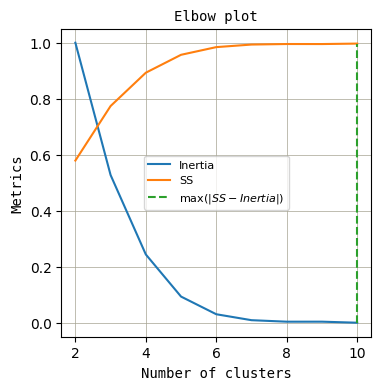

In [59]:
# Elbow plot
plt.figure(figsize=(4, 4))
plt.plot(n_clusters, inertias_rescaled, color='C0', label='Inertia')
plt.plot(n_clusters, mean_ss, color='C1', label='SS')
plt.plot([k_opt, k_opt], [inertias_rescaled.flatten()[k_opt-2], np.array(mean_ss)[k_opt-2]], ls='--', color='C2', label='$\max(|SS-Inertia|)$')
plt.xlabel('Number of clusters', size=10, family='monospace')
plt.ylabel('Metrics', size=10, family='monospace')
plt.legend(fontsize=8)
plt.title('Elbow plot', size=10, family='monospace')
plt.grid(lw=0.5, color='xkcd:cement');

In [60]:
model_kmeans = KMeans(n_clusters=k_opt, n_init='auto', random_state=seed)
c = model_kmeans.fit_predict(X)

Finally, since it is unimaginable how to assess 104-dimension data, let's embed our features into a much smaller dimension space. We may want to "reduce" the dimensionality to at least three or better two coordinates. To do that, let's use the well-known Stochastic Neighbor Embedding with $t$-distribution algorithm. We will display message headers for the embedded points. Each such header will be colored as per the message's cluster number. So, ideally we should see similar messages, in terms of their bodies "meanings", clustered together and having the same color. On the contrary, message having non-overlapping "meanings" should be spread apart and have different colors.

> Important note: The whole idea of extracting and comparing "meanings" with NLP models is based on the the so-called distributional semantics _hypothesis_: linguistic items with similar distributions have similar meanings. So, care should be taken when assessing results obtained using purely distributional (mathematical) approaches to work with word and text meanings in a broader sense. Decision-making is totally at the researcher's discretion.

In [61]:
# Message headers
headers = df.select('header').toPandas()['header'].tolist()

In [62]:
# Embed message tokenized bodies into 2d vector space with t-SNE
# Note:
# (1) PCA init is not available for sparse matrices (our case), thus random init is used.
# (2) For that reason, there is no guarantee that two identical points (header/body) are mapped to the same low dimensional point
# https://stackoverflow.com/questions/75173822/the-sklearn-manifold-tsne-gives-different-results-for-same-input-vectors
model_tsne = TSNE(n_components=2, init='random', n_jobs=-1, random_state=seed)

In [63]:
X_tsned = model_tsne.fit_transform(X)

In [64]:
print(f'{model_tsne.learning_rate_ = }')
print(f'{model_tsne.kl_divergence_ = }')

model_tsne.learning_rate_ = 465.3541666666667
model_tsne.kl_divergence_ = 3.22421932220459


Now each message has only 2 new features (coordinates), instead of 104 which we had initially after tf-idf encoding.

In [65]:
X_tsned

array([[-18.197277 ,  -8.686308 ],
       [-18.197092 ,  -8.686219 ],
       [ 27.51425  ,  12.208876 ],
       ...,
       [  5.6797004, -13.398742 ],
       [  4.5499406,  -8.912752 ],
       [  2.85576  , -10.157701 ]], dtype=float32)

In [66]:
# Scale values to be in [0, 1]
X_tsned_scaled = MinMaxScaler((0, 1)).fit_transform(X_tsned)
X_tsned_scaled

array([[3.2931566e-05, 1.8960173e-01],
       [3.6597252e-05, 1.8960400e-01],
       [9.1090220e-01, 7.2196138e-01],
       ...,
       [4.7581676e-01, 6.9540113e-02],
       [4.5330462e-01, 1.8383248e-01],
       [4.1954559e-01, 1.5211415e-01]], dtype=float32)

Number of unique headers

In [67]:
df.select(countDistinct('header')).show()

+----------------------+
|count(DISTINCT header)|
+----------------------+
|                    23|
+----------------------+



In [68]:
def colorize(df):
    red, green, blue, _ = cm.Dark2_r(df['cluster']/k_opt, bytes=True)
    return [f'color: rgb({str(red)},{str(green)},{str(blue)})'] * len(df)

In [69]:
# Add color as the cluster number
result_df = pd.concat([pd.DataFrame(X_tsned_scaled, columns=['tsne_x', 'tsne_y']), pd.Series(headers, name='header'), pd.Series(c, name='cluster')], axis=1)
# Take mean of all vectors for the same header
result_df = result_df.groupby('header').mean().reset_index()
result_df['color'] = MinMaxScaler((0, 1)).fit_transform(result_df[['cluster']])
result_df['header_short'] = result_df['header'].str.split('-', expand=True)[2]
result_df.sort_values(by='cluster')[['header_short', 'cluster']].reset_index(drop=True)\
.style\
    .format(subset='cluster', precision=0)\
    .apply(colorize, axis=1)\
    .set_caption('<h4>Unique message headers and their clusters</h4>')

,header_short,cluster
0,EndPointUnregistered,0
1,LastOutOfServiceInformation,1
2,AdministrativeEvent,2
3,RecordingCallSetupFail,3
4,DeviceTLInfo,4
5,EndPointTransientConnection,5
6,DeviceTransientConnection,5
7,CtiLineOpenFailure,6
8,CtiDeviceOpenFailure,6
9,DeviceUnregistered,6


Cluster 7 is the most populous.

##### <a id="plot"></a>6. Plot Results

Now it's time to visualize our results.

In [70]:
def plot_results(clusters=None, lims=None):

    result_df_clip = result_df
    if clusters is not None:
        result_df_clip = result_df_clip[result_df_clip['cluster'].isin(clusters)]

    if lims is not None:
        result_df_clip = result_df_clip[
                                (result_df_clip['tsne_x'] >= lims[0]) &
                                (result_df_clip['tsne_x'] <= lims[1]) &
                                (result_df_clip['tsne_y'] >= lims[2]) &
                                (result_df_clip['tsne_y'] <= lims[3])
                                ].reset_index(drop=True)
        
    x_shift = (result_df_clip['tsne_x'].max() - result_df_clip['tsne_x'].min()) / 50
    y_shift = (result_df_clip['tsne_y'].max() - result_df_clip['tsne_y'].min()) / 40
    _, ax = plt.subplots(figsize=(6, 6))
    ax.set_facecolor((0.99, 0.99, 0.98))
    ax.scatter(result_df_clip['tsne_x'], result_df_clip['tsne_y'], c=cm.Dark2_r(result_df_clip['cluster']/k_opt), marker='o', s=25, alpha=0.75)
    for i in range(result_df_clip.shape[0]):
        textbox = offsetbox.AnnotationBbox(
                                            offsetbox=offsetbox.TextArea(
                                                s=result_df_clip['header_short'].iloc[i] + ':' + result_df_clip['cluster'].iloc[i].astype(int).astype(str), 
                                                textprops=dict(
                                                                c=cm.Dark2_r(result_df_clip['cluster'].iloc[i]/k_opt), 
                                                                family='monospace',
                                                                fontsize=10,
                                                                #weight='bold',
                                                                alpha=1)), 
                                                xy=result_df_clip[['tsne_x', 'tsne_y']].iloc[i] + y_shift, frameon=False)
        ax.add_artist(textbox)
    plt.xlim([plt.xlim()[0] - x_shift * 50, plt.xlim()[1] + x_shift * 50])
    plt.grid(lw=0.5, color='xkcd:cement')
    plt.title(f'Message headers embedded from $\mathbb{{R}}^{{{num_feat}}}$ into $\mathbb{{R}}^2$', size=10, family='monospace')
    plt.gca().set_axisbelow(True);

All headers.

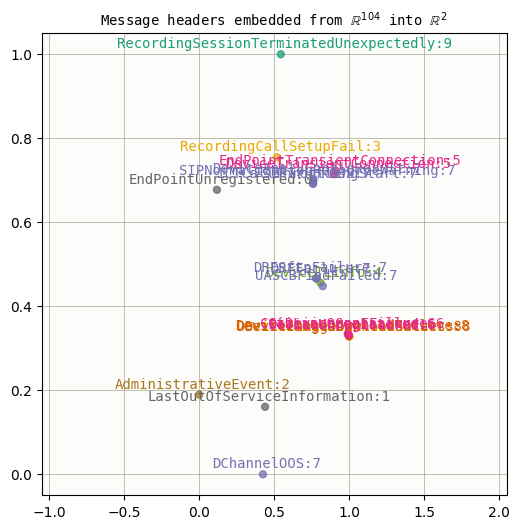

In [71]:
plot_results()

Our top "offender" message (cluster 0) looks to be rather distant from other messages indeed, which means that this issue should not be related to other events and thus should be examined further individually.

$t$-SNE put clusters 6 and 8 close to each other. Let's take a closer look at them.

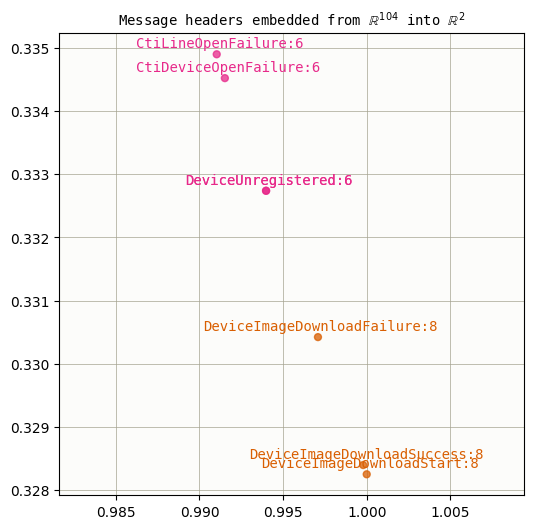

In [72]:
plot_results(clusters=[6, 8])

Looking at the headers, groupings seem to be reasonable.

Next, we can see that the cluster 4 and several messages in the cluster 7 sort of overlap as suggested by $t$-SNE. Again, looking at them closer.

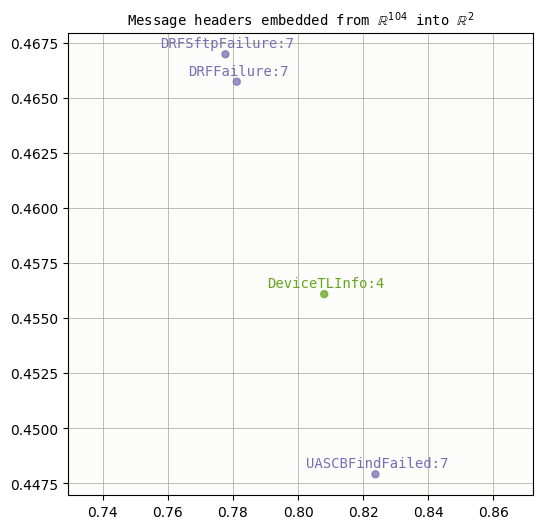

In [73]:
plot_results(clusters=[4, 7], lims=[0.6, 1.0, 0.4, 0.5])

Interestingly, cluster 7 is spread out in fact, as embedded by $t$-SNE.

Also, we can see that the cluster 5 and several messages in the cluster 7 lie closely together as suggested by $t$-SNE. Zooming in.

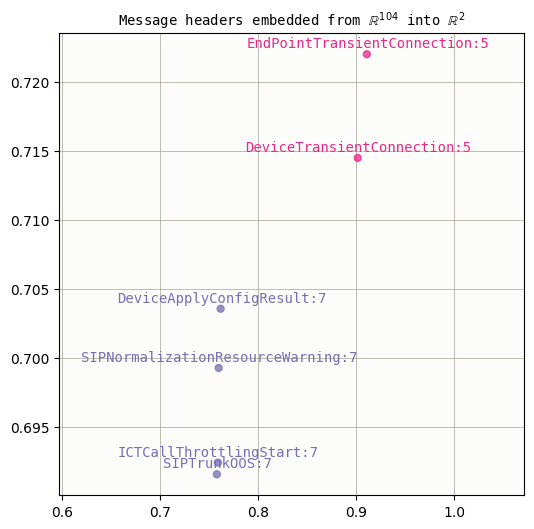

In [74]:
plot_results(clusters=[5, 7], lims=[0.6, 1.0, 0.6, 0.8])

Looking at the headers, groupings seem to be reasonable.

In [75]:
# Clean-up
sc.stop()

##### <a id="summary"></a>7. Summary

Overall, we were able to achieve our goal:
- syslog messages were divided into meaningful groups based on text analysis of message bodies,
- in general, K-Means clustering and $t$-SNE reduction converged to the same groups,
- there are also some divergences:
    - clusters 6 and 8 are believed to be closely embedded by $t$-SNE,
    - clusters 4 is believed to be closely embedded within cluster 7 by $t$-SNE,
    - cluster 7 is actually spread out into distant points after $t$-SNE reduction.

These results can be communicated to the customer.